# Making maps

I'm using a small dataset originally from [**Geoff Bohling**](http://people.ku.edu/~gbohling/) at the Kansas Geological Survey. I can no longer find the data online.

We will look at two ways to do this:

- Using SciPy with `scipy.interpolate.Rbf`
- Using the Scikit-Learn machine learning library with `sklearn.gaussian_process`


## Load and inspect the data

In [1]:
import numpy as np
import matplotlib.pyplot as plt

The data file is `../data/ZoneA.dat` (it's also on the web at `https://www.dropbox.com/s/6dyfc4fl5slhgry/ZoneA.dat?raw=1`)

### EXERCISE

Load the data from the text file into a Pandas DataFrame. <a title="Use Pandas's read_csv() method. You will need to set some arguments: sep, header, usecols, names, and dtype."><b>Hover for HINT</b></a>

We don't need all of the fields, but we at least need x, y, thickness and porosity. The top of the DataFrame should look something like this:

              x       y     thick       por
    0   12100.0  8300.0   37.1531   14.6515
    1    5300.0  8700.0   31.4993   14.5093
    
Once you have the data, can you make a KDE plot (`sns.kdeplot()`) with Seaborn?

In [2]:
# YOUR CODE HERE
fname = "../data/ZoneA.dat"



In [3]:
import pandas as pd

fname = "../data/ZoneA.dat"

df = pd.read_csv(fname,
                 sep=' ',
                 header=9,
                 usecols=[0, 1, 2, 3, 4],
                 names=['x', 'y', 'thick', 'por', 'perm'],
                 dtype="float64",
                 na_values=[-999.9999],
                )

df.head()

,x,y,thick,por,perm
0,12100.0,8300.0,37.1531,14.6515,2.8547
1,5300.0,8700.0,31.4993,14.5093,NaN
2,3500.0,13900.0,36.9185,14.0639,NaN
3,5100.0,1900.0,24.0156,15.1084,1.1407
4,9900.0,13700.0,35.0411,13.9190,NaN


<AxesSubplot:xlabel='por', ylabel='Density'>

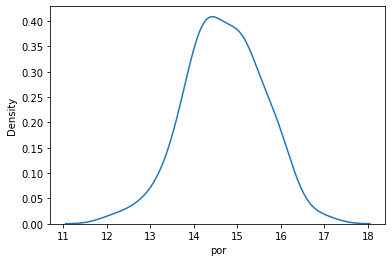

In [4]:
import seaborn as sns

sns.kdeplot(df.por)

This looks a bit unpleasant, but we're just getting out min and max values for the x and y columns.

In [5]:
extent = x_min, x_max, y_min, y_max = [df.x.min()-1000, df.x.max()+1000,
                                       df.y.min()-1000, df.y.max()+1000]

Later on, we'll see a nicer way to do this using the Verde library.

Now we can plot the data:

### EXERCISE

Make a map of the porosity data. Use the colour of the points to indicate porosity, and use the size to indicate thickness of the zone.

Add a colourbar, title, and other annotation.

In [6]:
# YOUR CODE HERE



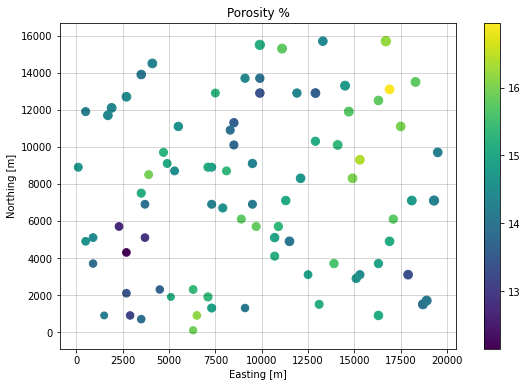

In [7]:
fig, ax = plt.subplots(figsize=(10,6))

scatter = ax.scatter(df.x, df.y, c=df.por, s=2*df.thick)
plt.colorbar(scatter)
ax.set_aspect(1)
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xlabel('Easting [m]')
ax.set_ylabel('Northing [m]')
ax.set_title('Porosity %')
ax.grid(c='k', alpha=0.2)

plt.show()

## Make a regular grid

We must make a grid, which represents the points we'd like to predict.

In [8]:
# Notice the order of x (columns) and y (rows)!
grid_y, grid_x = np.mgrid[y_min:y_max:500, x_min:x_max:500]

# Use *shape* argument to specify the *number* (not size) of bins:
# grid_y, grid_x = np.mgrid[y_min:y_max:100j, x_min:x_max:100j]

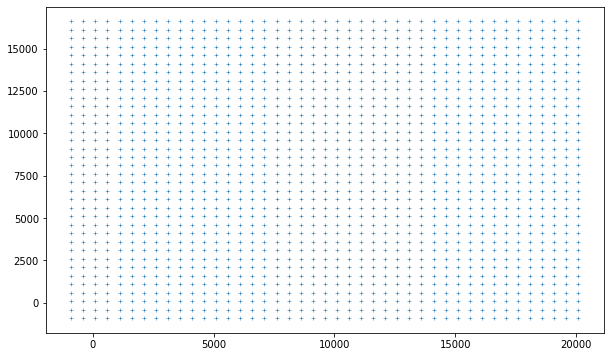

In [9]:
plt.figure(figsize=(10,6))
plt.scatter(grid_x, grid_y, marker='+', lw=0.5, s=10)

That was easy!

----

## Interpolation with radial basis function

Now we make an interpolator and use it to predict into the grid 'cells'.

In [13]:
from scipy.interpolate import Rbf

rbfi = 

SyntaxError: invalid syntax (<ipython-input-13-119f285cd22d>, line 3)

In [14]:
from scipy.interpolate import Rbf

# Make an n-dimensional interpolator. This is essential line number 4.
rbfi = Rbf(df.x, df.y, df.por, epsilon=1)

# Predict on the regular grid. Line 5.
di = rbfi(grid_x, grid_y)

Let's plot the result. First, we'll need the min and max of the combined sparse and gridded data, so we can plot them with the same colourmap ranges:

In [15]:
mi = np.min(np.hstack([di.ravel(), df.por.values]))
ma = np.max(np.hstack([di.ravel(), df.por.values]))

### EXERCISE

Can you make a plot of the interpolated surface, with the original data overplotted in the same colours?

You'll need to use `mi` and `ma` to control the colourbars. And you will need the transpose (`arr.T`)  and `imshow()`'s `origin='lower'` argument to keep everything matched up with the original dataset.

In [16]:
# YOUR CODE HERE



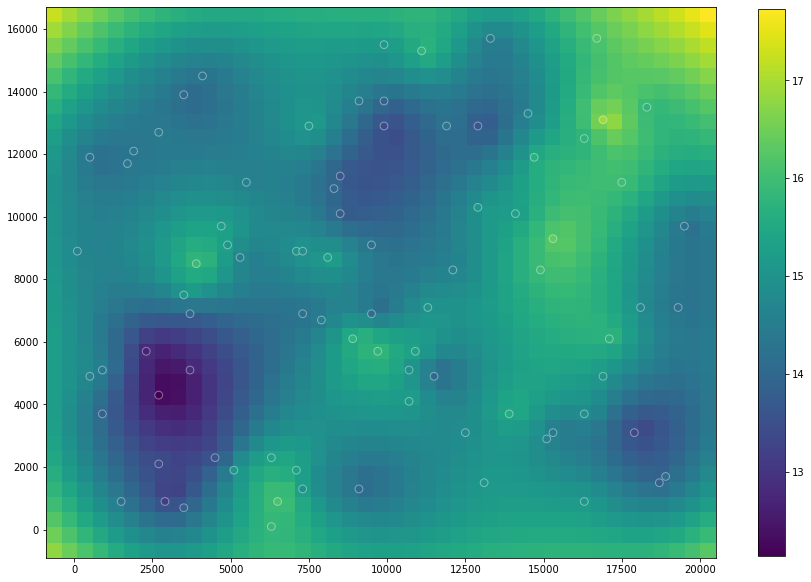

In [17]:
plt.figure(figsize=(15,15))
c1 = plt.imshow(di, origin="lower", extent=extent, vmin=mi, vmax=ma)
c2 = plt.scatter(df.x, df.y, s=60, c=df.por, edgecolor='#ffffff66', vmin=mi, vmax=ma)

plt.colorbar(c1, shrink=0.67)
plt.show()

The circles (the data) are the same colour as the grid (the model), so we can see that the error on this prediction is almost zero. In fact, the default parameters force the model to pass through all the data points (interpolation, as opposed to estimation or approximation).

### EXERCISE

Make a histogram and kernel density estimation of the residuals. <a title="Make predictions at the original input locations then subtract the original porosity data from those. Use sns.distplot() to plot them."><b>Hover for HINT</b></a>

Repeat the exercise but change the smoothing parameter (e.g. to 0.2) to see the effect on the residuals.

In [18]:
# YOUR CODE HERE



C:\Users\matt\miniconda3\envs\geoml\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='por', ylabel='Density'>

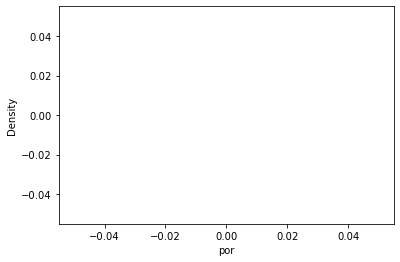

In [19]:
por_hat = rbfi(df.x, df.y)

sns.kdeplot(por_hat - df.por)

The `Rbf()` interpolator has [a few options](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.Rbf.html). The most important one is probably `smooth`, which is the thing to increase if you end up with a singular matrix (because it can't converge on a solution). Anything above 0 relaxes the constraint that the surface must pass through every point. If you get an error, you probably need to change the smoothing.

You can also change the `function` (default is `multiquadric`, which also has an `epsilon` parameter to vary the range of influence of each point).

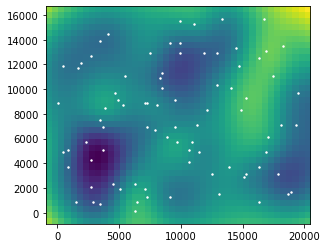

In [20]:
rbfi = Rbf(df.x, df.y, df.por, smooth=0.2)
di = rbfi(grid_x, grid_y)

plt.imshow(di, origin="lower", extent=extent)
plt.scatter(df.x, df.y, s=2, c='w')
plt.show()

### EXERCISE

Make an interactive plot to see the effect of the smoothing parameter on `Rbf`.

In [21]:
# YOUR CODE HERE



In [22]:
from ipywidgets import interact

@interact(smooth=(0, 1, 0.1), epsilon=(100, 5_000, 200))
def main(smooth, epsilon):
    rbfi = Rbf(df.x, df.y, df.por, smooth=smooth, epsilon=epsilon)

    di = rbfi(grid_x, grid_y)
    por_hat = rbfi(df.x, df.y)

    residuals = por_hat - df.por

    fig, axs = plt.subplots(ncols=2, figsize=(15, 5))

    mi = np.min(np.hstack([di.ravel(), df.por.values]))
    ma = np.max(np.hstack([di.ravel(), df.por.values]))

    im = axs[0].imshow(di, origin='lower', extent=extent, vmin=mi, vmax=ma)
    sns.scatterplot(x=df.x, y=df.y, hue=df.por, palette='viridis', vmin=mi, vmax=ma, ax=axs[0])

    sns.histplot(residuals, ax=axs[1])
    axs[1].set_xlim(-2, 2)
    
    fig.colorbar(im, ax=axs[0], shrink=0.8)
    
    plt.show()
    return

interactive(children=(FloatSlider(value=0.0, description='smooth', max=1.0), IntSlider(value=2500, description…

### EXERCISE

Use `plt.contour()` or `plt.contourf()` to make a contour map of this surface.

In [23]:
# YOUR CODE HERE



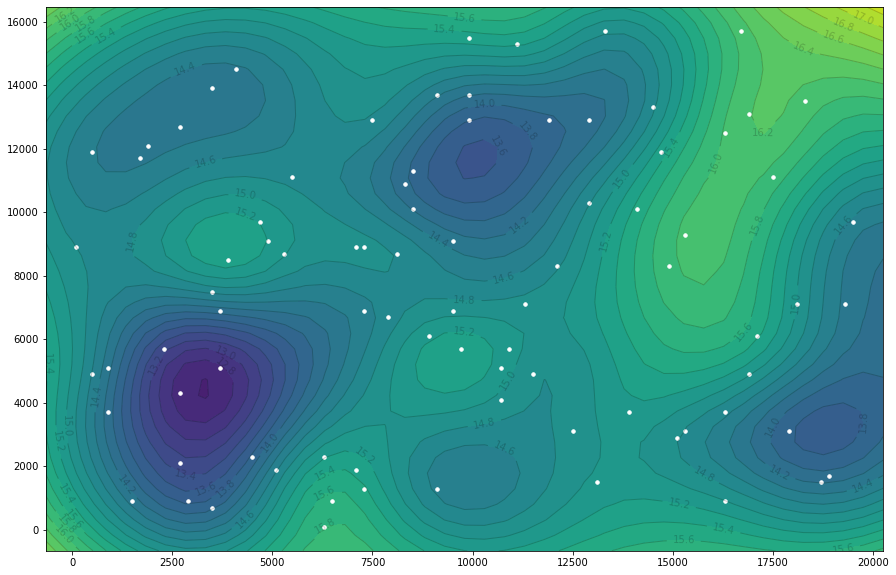

In [24]:
plt.figure(figsize=(15, 10))

plt.contourf(di, origin="lower", extent=extent,
             levels=np.arange(12, 18, 0.2),
            )

cs = plt.contour(di, origin="lower", extent=extent,
                 levels=np.arange(12, 18, 0.2),
                 linewidths=[1], colors=['k'], alpha=0.2
                )

plt.clabel(cs, fmt='%0.1f')

plt.scatter(df.x, df.y, s=12, c='w')

plt.show()

Finally, let's add the RBF interpolation to the dataframe:

In [25]:
rbfi = Rbf(df.x, df.y, df.por, smooth=0.2)
df['por_Rbf'] = rbfi(df.x, df.y)

----

## Using machine learning

Interpolation is a kind of regression (and, arguably, all prediction is interpolation... so all machine learning models are maps). And we have a bunch of different nonlinear regressors available to us in `scikit-learn`. So let's apply some of them to our problem.

We'll start with a Gaussian process model, which is the basis of the popular gridding approach **kriging**.

### Using `sklearn.gaussian_process`

Modeling with a Gaussian process is equivalent to kriging. Conveniently, the popular machine learning library `scikit-learn` has a Gaussian process modeling tool.

In [10]:
from sklearn.gaussian_process.kernels import RBF

kernel = RBF(length_scale=1000)

The main hyperparameters are the kernel, which we just defined, and `alpha`, which controls the smoothness. Larger values imply mmore noise in the input data, and result in smoother grids; default is very small: 1 &times; 10<sup>-9</sup>.

In [11]:
from sklearn.gaussian_process import GaussianProcessRegressor

gp = GaussianProcessRegressor(normalize_y=True,
                              alpha=0.1,  # Larger values imply more noise in the input data.
                              kernel=kernel,)

gp.fit(df[['x', 'y']].values, df.por.values)

GaussianProcessRegressor(alpha=0.1, kernel=RBF(length_scale=1e+03),
                         normalize_y=True)

To make a prediction, we need to construct the X matrix: (x, y) coordinates in 2 columns:

In [12]:
X_grid = np.stack([grid_x.ravel(), grid_y.ravel()]).T

Now we can make a prediction:

In [13]:
y_grid = gp.predict(X_grid).reshape(grid_x.shape)

And plot the predicted grid with the input data using the same colourmap:

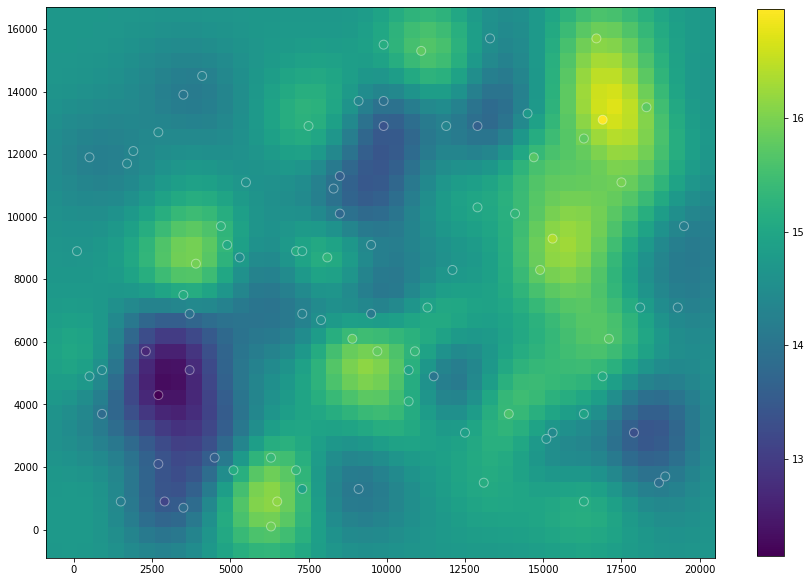

In [14]:
# Compute min and max of all the data:
mi = np.min(np.hstack([y_grid.ravel(), df.por.values]))
ma = np.max(np.hstack([y_grid.ravel(), df.por.values]))

# Plot it all.
plt.figure(figsize=(15,15))
im = plt.imshow(y_grid, origin='lower', extent=extent, vmin=mi, vmax=ma)
pts = plt.scatter(df.x, df.y, c=df.por, s=80, edgecolor='#ffffff66', vmin=mi, vmax=ma)
plt.colorbar(im, shrink=0.67)
plt.show()

As before, we can compute the error by making a prediction on the original (x, y) values and comparing to the actual measured porosities at those locations:

<AxesSubplot:xlabel='por', ylabel='Density'>

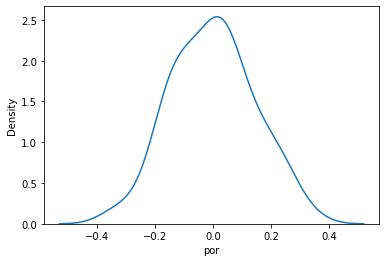

In [15]:
por_hat = gp.predict(df[['x', 'y']].values)

sns.kdeplot(por_hat - df.por)

In [16]:
df['por_GP'] = gp.predict(df[['x', 'y']].values)

sns.kdeplot(df['por_Rbf'] - df.por, label='RBF')
sns.kdeplot(df['por_GP'] - df.por, label='GP')
plt.legend()
plt.show()

KeyError: 'por_Rbf'

## Going further

The GP model actually models the distribution, not just the mean (which is also the most likely or mode and the P50 or median, for a normal distribution). So we can also look at a sample from the distribution:

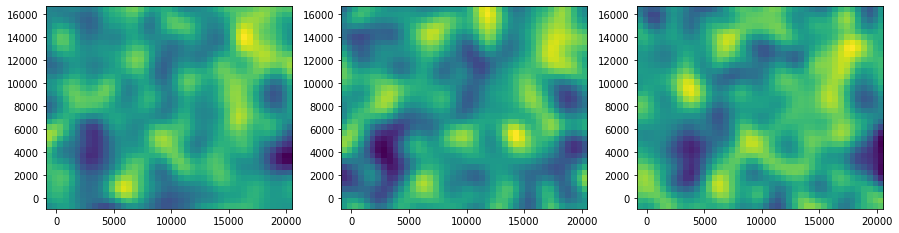

In [17]:
y_sample = gp.sample_y(X_grid, n_samples=3, random_state=42)

fig, axs = plt.subplots(ncols=3, figsize=(15, 5))
for ax, y_hat in zip(axs, y_sample.T):
    im = ax.imshow(y_hat.reshape(grid_x.shape), origin='lower', extent=extent)
plt.show()

Let's look at a cross-section.

We'll want the 'wells' on there at some point, so let's add grid-cell coordinates. (A better way to do this would be to use `xarray`.)

In [18]:
df['x_grid'] = (df.x - x_min) // 500
df['y_grid'] = (df.y - y_min) // 500

Now we can get the mean and stdev of the prediction:

In [19]:
y_grid, y_std = gp.predict(X_grid, return_std=True)

y_grid = y_grid.reshape(grid_x.shape)
y_std = y_std.reshape(grid_x.shape)

Then choose a row to look at, and filter the wells down to near that row:

In [ ]:
row = 19
wells = df[abs(df.y_grid - row) <= 1]

Let's check where that row and its wells are:

In [ ]:
plt.figure(figsize=(15, 10))
im = plt.imshow(y_grid, origin='lower', extent=extent, vmin=mi, vmax=ma)
pts = plt.scatter(df.x, df.y, c=df.por, s=80, edgecolor='#ffffff66', vmin=mi, vmax=ma)
pts = plt.scatter(wells.x, wells.y, c='r', s=80, edgecolor='k')
plt.colorbar(im, shrink=0.67)
plt.axhline(y_min + 19 * 500, c='red')
plt.show()

And compute various things:

In [ ]:
# Confidence interval.
phi, s = y_grid[row], y_std[row]
max_ = phi - 1.96 * s  # 95% confidence interval
min_ = phi + 1.96 * s  #     = 1.96 * stdev

# Draw some samples.
y_samples = gp.sample_y(X_grid, n_samples=5)

# Plot.
plt.figure(figsize=(15, 5))
for i, well in wells.iterrows():
    plt.scatter(well.x_grid, well.por, c='red', ec='k', s=50, zorder=100)
plt.plot(phi, c='darkblue', lw=5)
for sample in y_samples.T:
    plt.plot(sample.reshape(grid_x.shape)[row])
plt.fill_between(range(phi.size), min_, max_, alpha=0.2)
plt.show()

## More models!

### EXERCISE

Try some other regressors in `scikit-learn`. Look at the maps they produce, and check their residuals. (You might want to write a loop to check several models.)

Which regressors produce the best maps? 

In [33]:
# YOUR CODE HERE



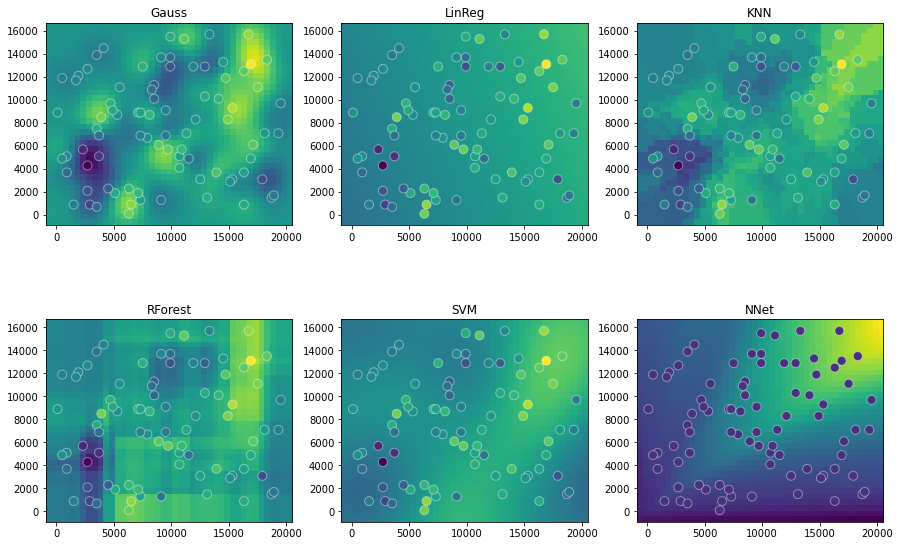

In [34]:
from sklearn.experimental import enable_hist_gradient_boosting

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.svm import SVR
from scipy.interpolate import Rbf


models =  {
    'Analytic': Rbf(df.x, df.y, df.por, smooth=0.1, function='multiquadric'), # Not an sklearn model!
    'k-NN': KNeighborsRegressor(n_neighbors=5),
    'SVM': SVR(C=10),
    'Random forest': RandomForestRegressor(max_depth=7),
    'Gradient boosted': HistGradientBoostingRegressor(min_samples_leaf=5),
    'Gaussian process': GaussianProcessRegressor(normalize_y=True, alpha=0.1, kernel=kernel),
}

fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(15, 10))

for (model, regr), ax in zip(models.items(), axs.ravel()):
    if model == 'Analytic':
        y_grid = regr(grid_x, grid_y)  # scipy provides a function here.
    else:
        regr.fit(df[['x', 'y']].values, df.por.values)
        y_grid = regr.predict(X_grid).reshape(grid_x.shape)
    
    mi = np.min(np.hstack([y_grid.ravel(), df.por.values]))
    ma = np.max(np.hstack([y_grid.ravel(), df.por.values]))

    im = ax.imshow(y_grid, origin='lower', cmap='viridis', extent=extent, vmin=mi, vmax=ma)
    pts = ax.scatter(df.x, df.y, c=df.por, s=80, cmap='viridis', edgecolor='#ffffff66', vmin=mi, vmax=ma)
    ax.set_title(model)

plt.show()

## Superpowers with `verde`

The geophysical package `verde` contains still more gridding algorithms, and makes some aspects of the gridding much easier — for example reducing the nuber of points in the dataset in sensible ways. [Read about it.](https://www.leouieda.com/blog/introducing-verde.html)

### Using verde.Spline

One of the options in scipy's Rbf interpolator is the "thin-plate" kernel. This is what the `verde.Spline` interpolator is based on but with a few modifications, like damping regularization to smooth the solution. It's similar to the `RBF` and `GaussianProcessRegressor` approach but Verde provides a more convenient API for gridding tasks.

For example, we now have a nicer way to define extent, using `vd.pad_region()`:

In [ ]:
import verde as vd

extent = x_min, x_max, y_min, y_max = vd.pad_region(vd.get_region((df.x, df.y)), pad=1000)

The API is partially based on that of `sklearn`:

In [ ]:
spline = vd.Spline(mindist=2000, damping=1e-4)
spline.fit((df.x, df.y), df.por)

To make a grid, use the `.grid()` method of the spline:

In [ ]:
grid = spline.grid(region=extent, spacing=500)
grid

This returns an `xarray.Dataset` which can be easily plotted, saved to disk as netCDF, or used for computations. The coordinates for the grid are automatically generated and populated based on the desired region and spacing. The spacing is adjusted to fit the desired region exactly. Optionally, you can set `adjust="region"` to adjust the size of the region so that the spacing is exact.

And plot the predicted grid with the input data using the same colourmap:

In [ ]:
# Compute min and max of all the data:
mi = np.min(np.hstack([grid.scalars.values.ravel(), df.por.values]))
ma = np.max(np.hstack([grid.scalars.values.ravel(), df.por.values]))

# Plot it all.
plt.figure(figsize=(15,15))
im = plt.imshow(grid.scalars, origin='lower', extent=extent, vmin=mi, vmax=ma)
pts = plt.scatter(df.x, df.y, c=df.por, s=80, edgecolor='#ffffff66', vmin=mi, vmax=ma)
plt.colorbar(im, shrink=0.67)
plt.show()

As before, we can compute the error by making a prediction on the original (x, y) values and comparing to the actual measured porosities at those locations:

In [ ]:
por_hat = spline.predict((df.x, df.y))

sns.displot(por_hat - df.por)

## Geostatistical approaches

The geostatistical package `gstools` implements various kriging algorithms, which some people may be more familiar with. [Check it out](https://github.com/GeoStat-Framework/GSTools). 

----

<center>&copy; 2021 Agile Scientific, licensed CC-BY</center>